In [2]:
import h5py
import s3fs
import io
from tqdm import tqdm

def load_master_gloss_list_from_s3(s3, s3_path):
    """
    Carga la lista maestra de glosas desde un archivo de texto en S3.
    """
    try:
        print(f"Cargando lista de etiquetas desde '{s3_path}'...")
        with s3.open(s3_path, 'r') as f:
            glosses = [line.strip() for line in f if line.strip()]
        print(f"✅ Lista maestra de {len(glosses)} etiquetas cargada.")
        return glosses
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo de etiquetas en '{s3_path}'.")
        return None

def create_segmented_h5_on_s3(s3, s3_input_path, s3_output_path, glosses_to_keep):
    """
    Crea un nuevo archivo H5 en S3 copiando solo los videos cuyas glosas
    están en la lista proporcionada.
    """
    videos_copied_count = 0
    glosses_set = set(glosses_to_keep)
    
    try:
        # Abre el archivo H5 de entrada desde S3
        with s3.open(s3_input_path, 'rb') as s3_file:
            with h5py.File(s3_file, 'r') as f_in:
                # Usa un búfer en memoria para construir el nuevo archivo H5
                with io.BytesIO() as buffer:
                    with h5py.File(buffer, 'w') as f_out:
                        for video_id in f_in.keys():
                            # Verifica que el video tenga el atributo 'gloss'
                            if 'gloss' in f_in[video_id].attrs:
                                current_gloss = f_in[video_id].attrs['gloss']
                                if current_gloss in glosses_set:
                                    f_in.copy(video_id, f_out)
                                    videos_copied_count += 1
                    
                    # Sube el archivo completo desde el búfer a S3
                    with s3.open(s3_output_path, 'wb') as s3_out_file:
                        s3_out_file.write(buffer.getvalue())

        print(f"      -> Creado '{s3_output_path.split('/')[-1]}'. Se copiaron {videos_copied_count} videos.")
    except Exception as e:
        print(f"❌ Error al procesar '{s3_input_path.split('/')[-1]}': {e}")


def main():
    """
    Función principal que orquesta el proceso de segmentación en S3.
    """
    # --- 1. Configuración de Rutas S3 ---
    INPUT_BASE_PATH = "s3://representatiohorarum/Datasets/luego de frames negros/"
    OUTPUT_BASE_PATH = "s3://representatiohorarum/Datasets/Fragmentos/"
    MASTER_GLOSS_S3_PATH = "s3://representatiohorarum/Etiquetas.txt"
    
    SOURCE_FILES = ["ISL_negro.h5", "SLOVO_negro.h5", "WLSL_negro.h5"]
    SEGMENT_SIZES = [5, 10, 20, 35, 50, 72]

    # --- 2. Preparación ---
    print("Iniciando el proceso de segmentación de archivos H5 desde S3...")
    s3 = s3fs.S3FileSystem()
    
    master_gloss_list = load_master_gloss_list_from_s3(s3, MASTER_GLOSS_S3_PATH)
    if master_gloss_list is None:
        return

    print(f"Los archivos fragmentados se guardarán en: '{OUTPUT_BASE_PATH}'\n")

    # --- 3. Bucle Principal de Segmentación ---
    for size in tqdm(SEGMENT_SIZES, desc="Progreso General (Tamaños)"):
        print(f"\n--- ✂️  Preparando fragmentos de {size} etiquetas ---")
        
        glosses_for_this_segment = master_gloss_list[:size]
        
        for source_filename in SOURCE_FILES:
            s3_input_path = INPUT_BASE_PATH + source_filename
            
            if not s3.exists(s3_input_path):
                print(f"   ⚠️  Advertencia: No se encontró '{s3_input_path}'. Saltando este archivo.")
                continue

            # Crear el nombre del archivo de salida, ej: "ISL_5gloss.h5"
            base_name = source_filename.split('_')[0]
            output_filename = f"{base_name}_{size}gloss.h5"
            s3_output_path = OUTPUT_BASE_PATH + output_filename
            
            # Llamar a la función que filtra y copia en S3
            create_segmented_h5_on_s3(s3, s3_input_path, s3_output_path, glosses_for_this_segment)
            
    print("\n✅ ¡Proceso de segmentación completado!")

# --- Ejecutar el script ---
if __name__ == "__main__":
    main()

Iniciando el proceso de segmentación de archivos H5 desde S3...
Cargando lista de etiquetas desde 's3://representatiohorarum/Etiquetas.txt'...
✅ Lista maestra de 93 etiquetas cargada.
Los archivos fragmentados se guardarán en: 's3://representatiohorarum/Datasets/Fragmentos/'



Progreso General (Tamaños):   0%|          | 0/6 [00:00<?, ?it/s]


--- ✂️  Preparando fragmentos de 5 etiquetas ---
      -> Creado 'ISL_5gloss.h5'. Se copiaron 99 videos.
      -> Creado 'SLOVO_5gloss.h5'. Se copiaron 120 videos.


Progreso General (Tamaños):  17%|█▋        | 1/6 [00:38<03:11, 38.34s/it]

      -> Creado 'WLSL_5gloss.h5'. Se copiaron 59 videos.

--- ✂️  Preparando fragmentos de 10 etiquetas ---
      -> Creado 'ISL_10gloss.h5'. Se copiaron 184 videos.
      -> Creado 'SLOVO_10gloss.h5'. Se copiaron 260 videos.


Progreso General (Tamaños):  33%|███▎      | 2/6 [01:12<02:23, 35.99s/it]

      -> Creado 'WLSL_10gloss.h5'. Se copiaron 113 videos.

--- ✂️  Preparando fragmentos de 20 etiquetas ---
      -> Creado 'ISL_20gloss.h5'. Se copiaron 368 videos.
      -> Creado 'SLOVO_20gloss.h5'. Se copiaron 480 videos.


Progreso General (Tamaños):  50%|█████     | 3/6 [01:51<01:51, 37.11s/it]

      -> Creado 'WLSL_20gloss.h5'. Se copiaron 213 videos.

--- ✂️  Preparando fragmentos de 35 etiquetas ---
      -> Creado 'ISL_35gloss.h5'. Se copiaron 626 videos.
      -> Creado 'SLOVO_35gloss.h5'. Se copiaron 840 videos.


Progreso General (Tamaños):  67%|██████▋   | 4/6 [02:33<01:18, 39.21s/it]

      -> Creado 'WLSL_35gloss.h5'. Se copiaron 348 videos.

--- ✂️  Preparando fragmentos de 50 etiquetas ---
      -> Creado 'ISL_50gloss.h5'. Se copiaron 835 videos.
      -> Creado 'SLOVO_50gloss.h5'. Se copiaron 1180 videos.


Progreso General (Tamaños):  83%|████████▎ | 5/6 [03:24<00:43, 43.51s/it]

      -> Creado 'WLSL_50gloss.h5'. Se copiaron 467 videos.

--- ✂️  Preparando fragmentos de 72 etiquetas ---
      -> Creado 'ISL_72gloss.h5'. Se copiaron 1128 videos.
      -> Creado 'SLOVO_72gloss.h5'. Se copiaron 1660 videos.


Progreso General (Tamaños): 100%|██████████| 6/6 [04:22<00:00, 43.77s/it]

      -> Creado 'WLSL_72gloss.h5'. Se copiaron 618 videos.

✅ ¡Proceso de segmentación completado!


In [4]:
import h5py
import s3fs
import matplotlib.pyplot as plt
import numpy as np

# --- Configuración ---
# Asegúrate de que esta ruta apunte al archivo que quieres verificar
s3_file_path = 's3://representatiohorarum/Datasets/Fragmentos/WLSL_10gloss.h5'

print(f"🔎 Inspeccionando el archivo: {s3_file_path}\n")

try:
    s3 = s3fs.S3FileSystem()
    with s3.open(s3_file_path, 'rb') as f:
        with h5py.File(f, 'r') as hf:
            
            video_ids = list(hf.keys())
            num_videos = len(video_ids)
            
            # 1. Imprimir resumen del contenido
            print("--- RESUMEN DEL ARCHIVO H5 ---")
            print(f"Total de videos encontrados: {num_videos}")
            print("-" * 30)

            if num_videos == 0:
                print("El archivo está vacío.")
            else:
                for video_id in video_ids:
                    group = hf[video_id]
                    frames = group['frames']
                    gloss = group.attrs.get('gloss', 'N/A')
                    
                    # Imprimir información detallada de cada video
                    print(f"▶ Video ID: {video_id}")
                    print(f"  - Etiqueta (Gloss): '{gloss}'")
                    print(f"  - Número de frames: {frames.shape[0]}")
                    print(f"  - Dimensiones de frames: {frames.shape[1:]} (Alto, Ancho)")
                    print(f"  - Tipo de datos: {frames.dtype}")

except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el archivo en la ruta: {s3_file_path}")
except Exception as e:
    print(f"❌ Ocurrió un error inesperado: {e}")

🔎 Inspeccionando el archivo: s3://representatiohorarum/Datasets/Fragmentos/WLSL_10gloss.h5

--- RESUMEN DEL ARCHIVO H5 ---
Total de videos encontrados: 113
------------------------------
▶ Video ID: 07932
  - Etiqueta (Gloss): 'brother'
  - Número de frames: 9
  - Dimensiones de frames: (224, 224) (Alto, Ancho)
  - Tipo de datos: uint8
▶ Video ID: 07933
  - Etiqueta (Gloss): 'brother'
  - Número de frames: 9
  - Dimensiones de frames: (224, 224) (Alto, Ancho)
  - Tipo de datos: uint8
▶ Video ID: 07934
  - Etiqueta (Gloss): 'brother'
  - Número de frames: 9
  - Dimensiones de frames: (224, 224) (Alto, Ancho)
  - Tipo de datos: uint8
▶ Video ID: 07935
  - Etiqueta (Gloss): 'brother'
  - Número de frames: 9
  - Dimensiones de frames: (224, 224) (Alto, Ancho)
  - Tipo de datos: uint8
▶ Video ID: 07936
  - Etiqueta (Gloss): 'brother'
  - Número de frames: 9
  - Dimensiones de frames: (224, 224) (Alto, Ancho)
  - Tipo de datos: uint8
▶ Video ID: 07937
  - Etiqueta (Gloss): 'brother'
  - Núme

--- Iniciando la visualización de la evolución de frames ---
Seleccionando un video aleatorio desde: WLSL_V03_glosscomun.h5...
✅ Video seleccionado: '49335'

Buscando la secuencia en todas las etapas del procesamiento...


Cargando etapas: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]



Generando el gráfico comparativo...


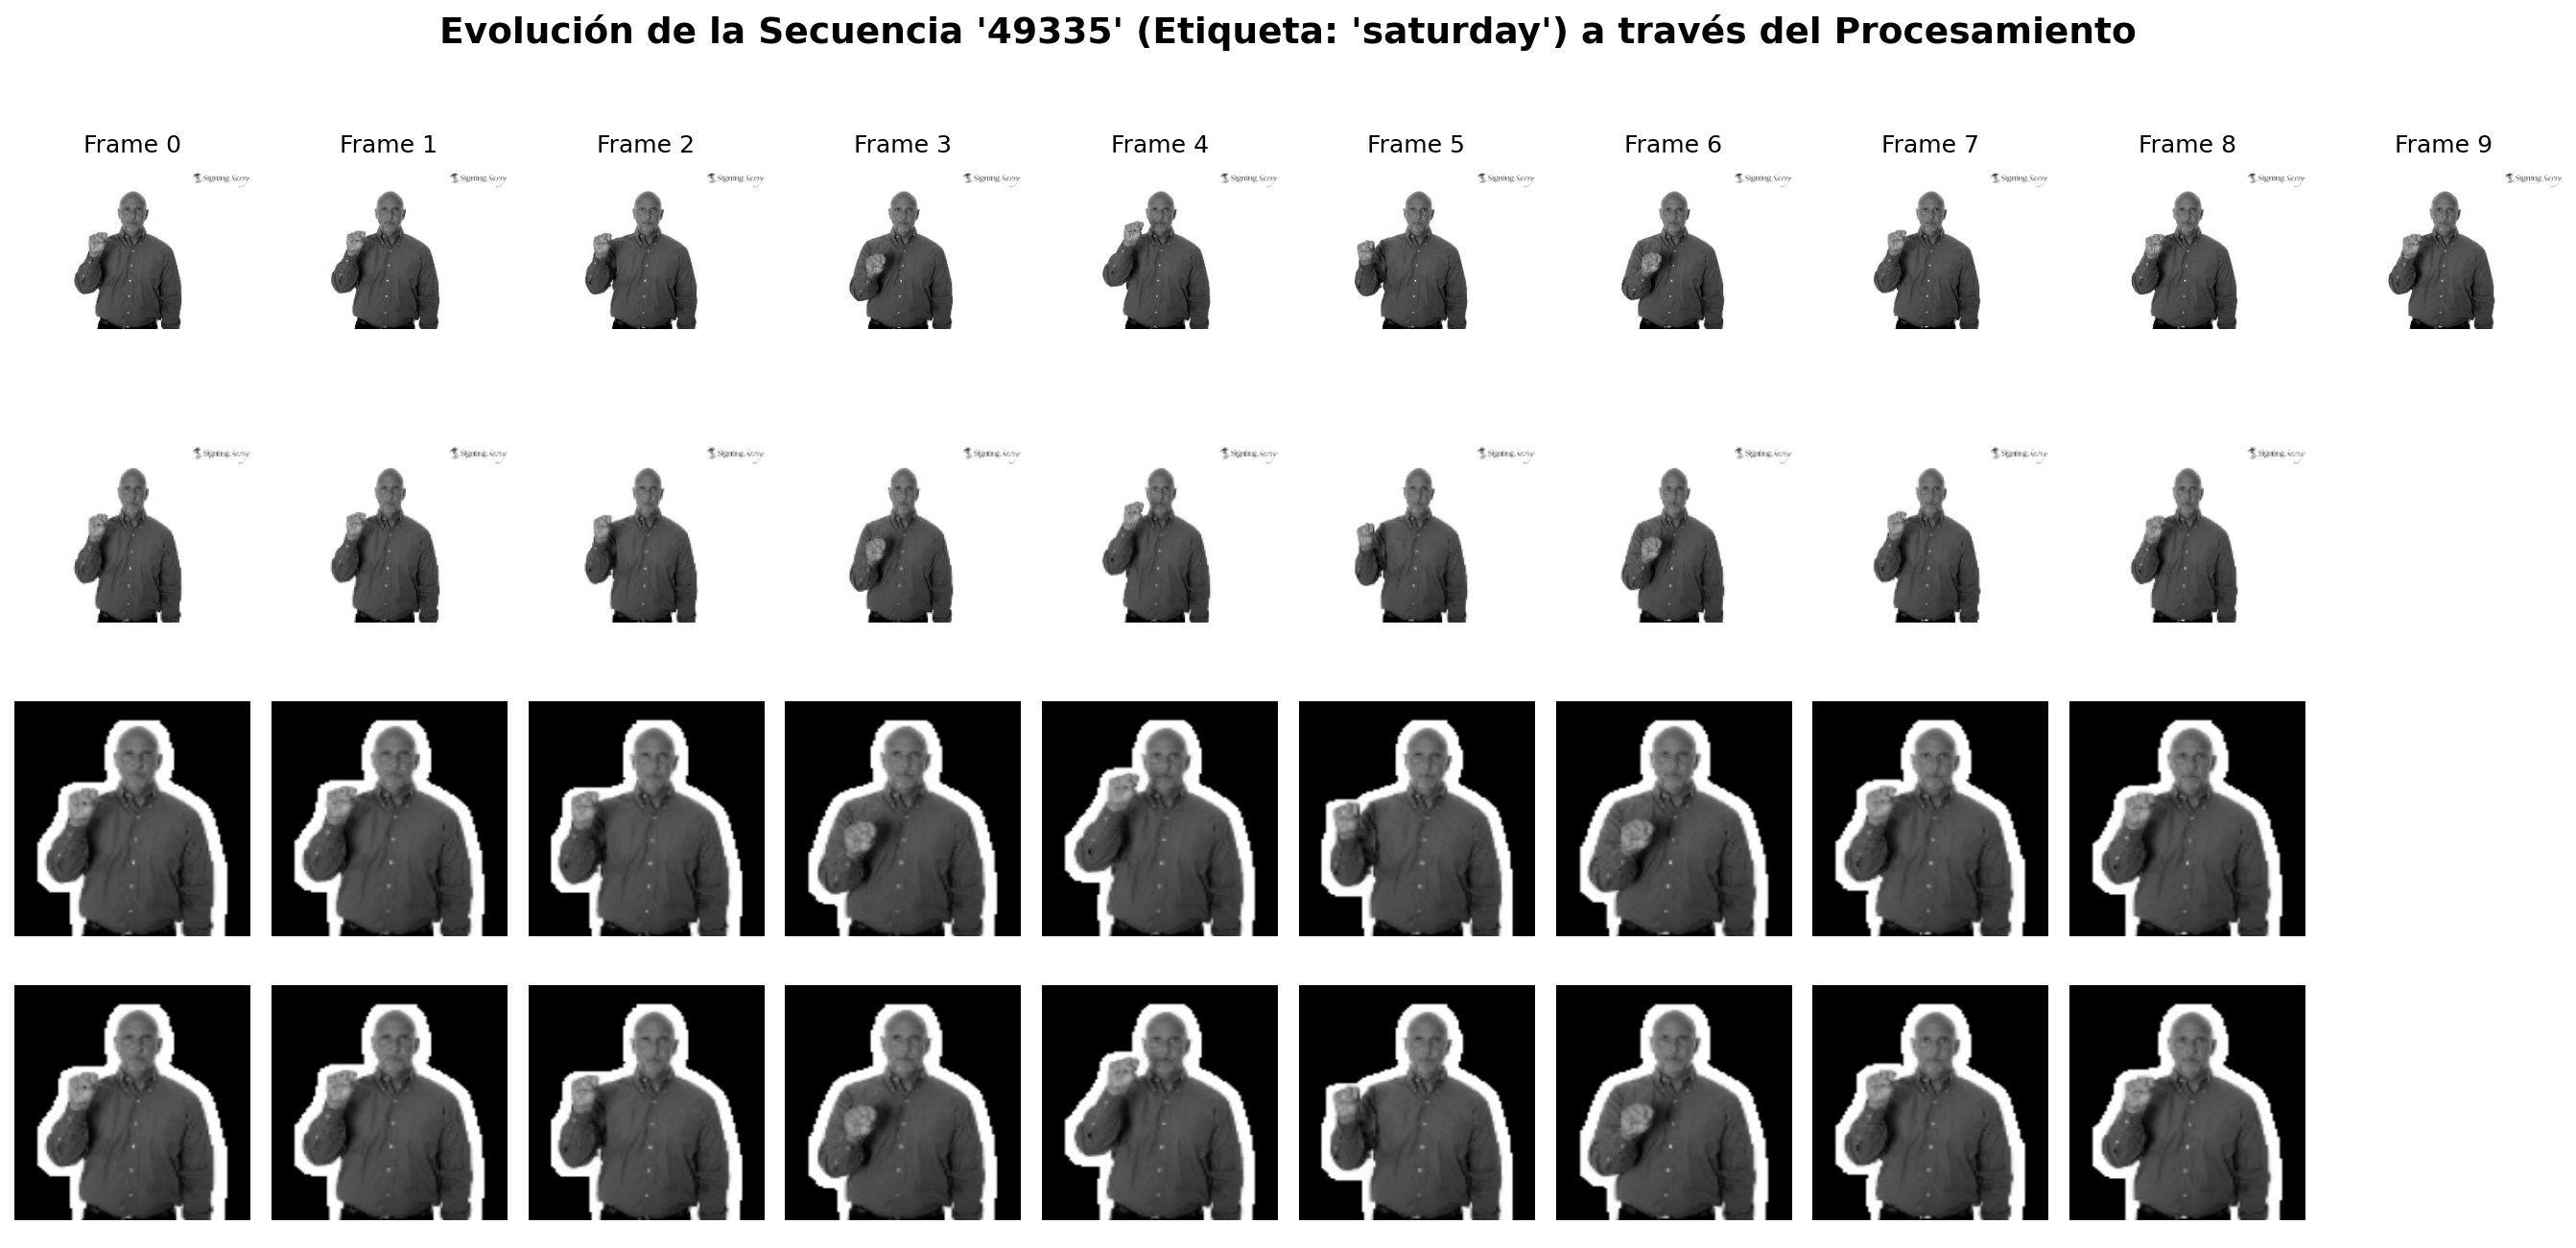

In [18]:
import h5py
import s3fs
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from tqdm import tqdm

def get_sequence_by_id(s3, s3_path, video_id):
    """
    Busca un video por su ID en un archivo H5 en S3 y devuelve sus frames y etiqueta.

    Args:
        s3 (s3fs.S3FileSystem): Instancia del sistema de archivos S3.
        s3_path (str): Ruta completa al archivo H5 en S3.
        video_id (str): Identificador único del video a buscar.

    Returns:
        tuple: Una tupla conteniendo (frames, gloss) si se encuentra, o (None, None) si no.
    """
    try:
        with s3.open(s3_path, 'rb') as s3_file:
            with h5py.File(s3_file, 'r') as hf:
                if video_id in hf:
                    frames = hf[video_id]['frames'][:]
                    gloss = hf[video_id].attrs.get('gloss', 'N/A')
                    return frames, gloss
                else:
                    return None, None
    except FileNotFoundError:
        print(f"  -> Advertencia: No se encontró el archivo {s3_path}")
        return None, None
    except Exception as e:
        print(f"  -> Error al leer {s3_path}: {e}")
        return None, None

def visualize_sequence_evolution():
    """
    Orquesta la selección, carga y visualización de la evolución de una secuencia de video
    a través de diferentes etapas de procesamiento.
    """
    # --- 1. Configuración de las Etapas y Rutas S3 ---
    STAGES = [
        {
            "label": "1. Original",
            "path": "s3://representatiohorarum/Datasets/Completos/WLSL_V03_glosscomun.h5"
        },
        {
            "label": "2. Recortado (Trim)",
            "path": "s3://representatiohorarum/Datasets/Luego del trim/WLSL_trim.h5"
        },
        {
            "label": "3. Fondo Eliminado",
            "path": "s3://representatiohorarum/Datasets/Luego del fondo/WLSL_fondo.h5"
        },
        {
            "label": "4. Frames Negros Reparados",
            "path": "s3://representatiohorarum/Datasets/luego de frames negros/WLSL_negro.h5"
        }
    ]

    print("--- Iniciando la visualización de la evolución de frames ---")
    s3 = s3fs.S3FileSystem()

    # --- 2. Seleccionar un Video Aleatorio del Dataset Original ---
    print(f"Seleccionando un video aleatorio desde: {STAGES[0]['path'].split('/')[-1]}...")
    try:
        with s3.open(STAGES[0]['path'], 'rb') as s3_file:
            with h5py.File(s3_file, 'r') as hf:
                all_video_ids = list(hf.keys())
                target_video_id = random.choice(all_video_ids)
        print(f"✅ Video seleccionado: '{target_video_id}'")
    except Exception as e:
        print(f"❌ No se pudo leer el archivo original para seleccionar un video. Error: {e}")
        return

    # --- 3. Cargar Todas las Versiones de la Secuencia Seleccionada ---
    sequences_to_plot = []
    main_gloss = "N/A"
    print("\nBuscando la secuencia en todas las etapas del procesamiento...")
    for stage in tqdm(STAGES, desc="Cargando etapas"):
        frames, gloss = get_sequence_by_id(s3, stage["path"], target_video_id)
        if frames is not None:
            sequences_to_plot.append({"label": stage["label"], "frames": frames})
            if gloss != 'N/A':
                main_gloss = gloss
        else:
            print(f"  -> No se encontró el video '{target_video_id}' en la etapa: '{stage['label']}'")

    if not sequences_to_plot:
        print("❌ No se pudo cargar ninguna secuencia. Abortando.")
        return

    # --- 4. Preparar y Generar la Visualización ---
    print("\nGenerando el gráfico comparativo...")
    num_rows = len(sequences_to_plot)
    num_cols = max(len(seq['frames']) for seq in sequences_to_plot)

    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=(num_cols * 1.8, num_rows * 2.2),
        dpi=150  # Alta resolución para calidad de publicación
    )
    
    # Asegura que 'axes' sea siempre 2D para una fácil indexación
    if num_rows == 1: axes = np.array([axes])
    if num_cols == 1: axes = axes.reshape(-1, 1)

    for row_idx, seq_data in enumerate(sequences_to_plot):
        frames = seq_data['frames']
        
        # Etiqueta de la Fila (Etapa del Proceso)
        axes[row_idx, 0].set_ylabel(
            seq_data['label'], rotation=0, size='large',
            labelpad=80, ha='right', va='center'
        )

        for col_idx in range(num_cols):
            ax = axes[row_idx, col_idx]
            
            if col_idx < len(frames):
                frame = frames[col_idx]
                
                # Etiqueta de la Columna (Número de Frame), solo en la primera fila
                if row_idx == 0:
                    ax.set_title(f"Frame {col_idx}", pad=10)

                # Detectar si el frame es color o escala de grises
                if frame.ndim == 3 and frame.shape[2] == 3: # Frame BGR
                    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                else: # Frame en escala de grises
                    ax.imshow(frame, cmap='gray')
                
                ax.axis('off')
            else:
                # Ocultar ejes vacíos si la secuencia es más corta
                ax.axis('off')

    fig.suptitle(
        f"Evolución de la Secuencia '{target_video_id}' (Etiqueta: '{main_gloss}') a través del Procesamiento",
        fontsize=18,
        fontweight='bold'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar para el supertítulo
    plt.show()

# --- Ejecutar el script ---
if __name__ == "__main__":
    visualize_sequence_evolution()